# Prediction with Machine Learning HW2
## Mukhamejan Assan

Business: Your task will be to help a company operating small and mid-size apartments hosting 2-6 guests. The company is set to price their new apartments not on the market. 

Build a price prediction model similarly to how we did in our case study for London. 

Discuss your modeling decisions and compare your results to those of the case study. 


## Part I. Accessing and Cleaning Data

In [210]:
import numpy as np

In [199]:
import pandas as pd 

df = pd.read_csv('listings.csv')
df.shape 

(11056, 75)

### The variables, their description, and type

In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11056 entries, 0 to 11055
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            11056 non-null  int64  
 1   listing_url                                   11056 non-null  object 
 2   scrape_id                                     11056 non-null  int64  
 3   last_scraped                                  11056 non-null  object 
 4   source                                        11056 non-null  object 
 5   name                                          11054 non-null  object 
 6   description                                   11018 non-null  object 
 7   neighborhood_overview                         7087 non-null   object 
 8   picture_url                                   11056 non-null  object 
 9   host_id                                       11056 non-null 

### EDA and sample definition and preparation

#### Missing values

There are 77284 missing values in total


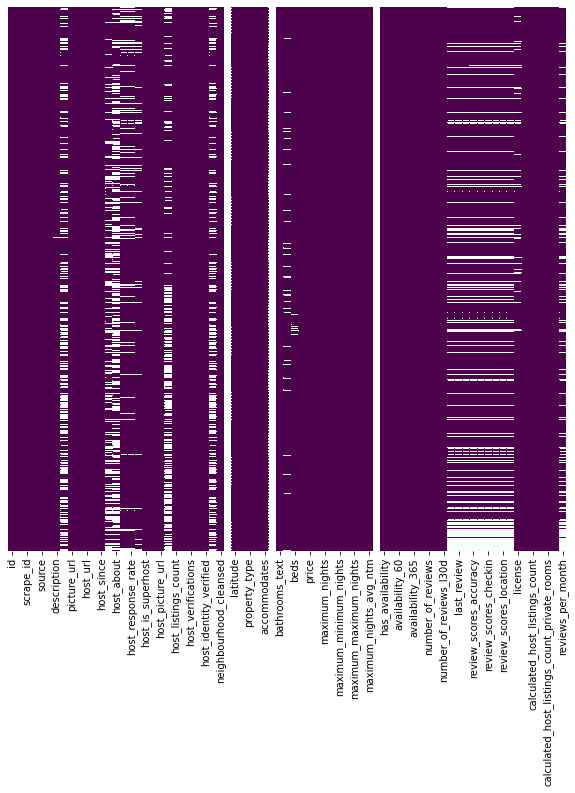

In [201]:
# Check for missing values frequency
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='BuPu_r', ax=ax)
print('There are', df.isna().sum().sum(), 'missing values in total')

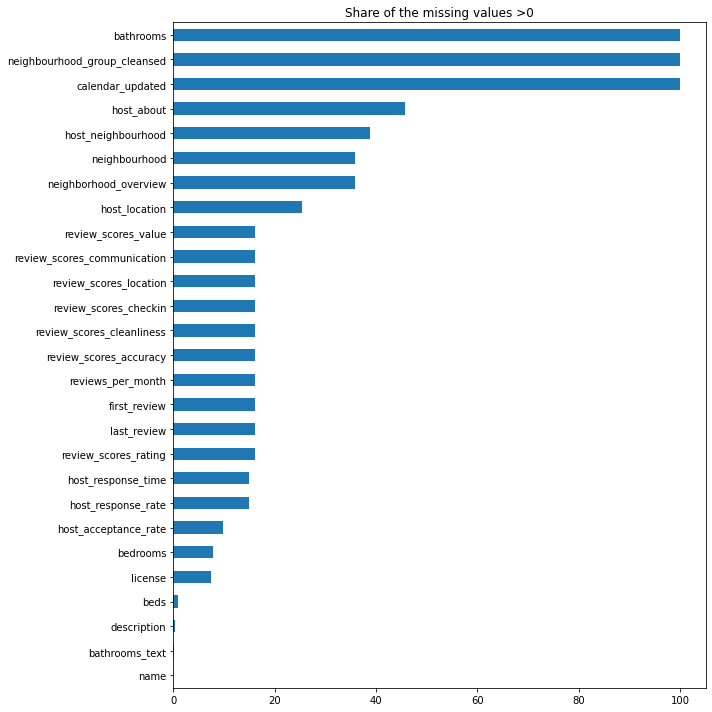

In [202]:
# focus on features with missing values
na_share = df.isnull().mean()*100
fig, ax = plt.subplots(figsize=(10,10))    
na_share[na_share>0].sort_values(ascending=True).plot.barh(title = 'Share of the missing values >0')
plt.tight_layout()

In [203]:
na_share[na_share>0].sort_values(ascending=False)

neighbourhood_group_cleansed    100.000000
calendar_updated                100.000000
bathrooms                       100.000000
host_about                       45.640376
host_neighbourhood               38.766281
neighborhood_overview            35.899059
neighbourhood                    35.899059
host_location                    25.479378
review_scores_value              16.199349
review_scores_communication      16.199349
review_scores_accuracy           16.190304
review_scores_location           16.190304
review_scores_cleanliness        16.190304
review_scores_checkin            16.190304
first_review                     16.018452
last_review                      16.018452
review_scores_rating             16.018452
reviews_per_month                16.018452
host_response_rate               14.914978
host_response_time               14.914978
host_acceptance_rate              9.723227
bedrooms                          7.742402
license                           7.407742
beds       

There is no way to impute the data that is missing 100% of the times, so I will have to drop them out of the features' list. 

In [204]:
unwanted = ['neighbourhood_group_cleansed', 'calendar_updated', 'bathrooms']

`host_about` is a description of a host written by themselves. Analyzing the text itself might not result in much predictive power, but we still can proxy its usefulness by the presence and the length of host's self-description. It could be that a listing with a description about the host might be perceived as more reliable.

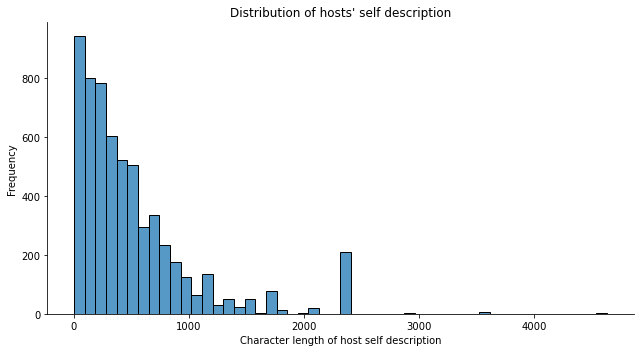

In [205]:
sns.displot(df.host_about.str.len().sort_values(), bins=50, kde=False, aspect = 1.8)
plt.title("Distribution of hosts' self description")
plt.xlabel('Character length of host self description')
plt.ylabel('Frequency')
plt.tight_layout()

In [206]:
df.host_about = df.host_about.str.len()
df.host_about.fillna(0, inplace=True)